In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data as web # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
import mplfinance as mpf # Matplotlib finance


In [14]:
risk_scatter_tickers = ['BTC-USD', 'SPY'] # As currrently defined (subject to change), 'Risk Levels' are not uniform across equities, so some manual input is required for meaningful buy and sell signals (for now)

In [1]:
def save_to_csv_yahoo(ticker):
    df = yfinance.download(ticker.strip(), period="MAX")
    df.to_csv(ticker + ".csv")
    return df

In [11]:
def get_df_from_csv(ticker):
    try:
        df = pd.read_csv('./'+ ticker + '.csv')
    except FileNotFoundError:
        print('File does not exist')
    else:
        return df
    

In [5]:
def download_multiple_stocks(tickers):
    tickers = tickers.split(' ')
    if(len(tickers) == 1):
        save_to_csv_yahoo(tickers[0])
    for x in tickers:
        save_to_csv_yahoo(x)

In [6]:
def define_risk(df):
    ma50 = 0
    for x in range(50):
        ma50 = df['Adj Close'].shift(x) + ma50
    df['ma50'] = ma50/50
    ma350 = 0
    for x in range(350):
        ma350 = df['Adj Close'].shift(x) + ma350
    df['ma350'] = ma350/350
    df['Risk'] = df['ma50']/df['ma350']
    
    
    max_value = df['Risk'].max()
    min_value = df['Risk'].min()
    df['Risk'] = (df['Risk'] - min_value) / (max_value - min_value)
    
    return df

In [7]:
def risk_below_level(risk,close):
#     import numpy as np
    signal   = []
    previous = -1.0
    for date,value in risk.iteritems():
        if value < 0.3 and previous >= 0.3:
            signal.append(close[date]*0.99)
        else:
            signal.append(np.nan)
        previous = value
    return signal

# Indicators

In [7]:
def define_risk(df, ticker):
    ma20 = 0 # To plot, because it's meaningful
    for x in range(140):
        ma20w = df['Adj Close'].shift(x) + ma20
    ma50 = 0 # To calculate 'Risk'
    # df['sma20'] = df['Adj Close'].rolling(window=20, min_periods=1).mean()
    df['sma50'] = df['Adj Close'].rolling(window=50, min_periods=1).mean()
    df['sma350'] = df['Adj Close'].rolling(window=350, min_periods=1).mean()
    df['Risk'] = df['sma50']/df['sma350'] # 'Risk'
    max_value = df['Risk'].max()
    min_value = df['Risk'].min()
    # if(min_value > 0):
    #     df['Risk'] = ((df['Risk'] - min_value) / (max_value - min_value))
    # elif(min_value < 0):
    #     df['Risk'] = ((df['Risk'] + min_value) / (max_value - min_value))
    # else:
    #     df['Risk'] = (df['Risk'] / max_value)
    df['Risk'] = (df['Risk'] - min_value) / (max_value - min_value)
    bbound1 = 0
    bbound2 = 0
    sbound1 = 1
    sbound2 = 1
    
    return df

In [8]:
def define_risk_scatter(df,ticker):
    if(ticker == 'SPY'):
        bbound1 = 0.7
        bbound2 = 0.6
        sbound1 = 0.8
        sbound2 = 0.9
    elif(ticker == 'BTC-USD'):
        bbound1 = 0.35
        bbound2 = 0.24
        sbound1 = 0.75
        sbound2 = 0.8
    else:
        bbound1 = 0.4
        bbound2 = 0.3
        sbound1 = 0.90
        sbound2 = 0.8

    df['BuySignal1'] = 0.0
    df['BuySignal1'] = np.where(df['Risk'] < bbound1, df['Adj Close'] * 0.95, np.nan)
    df['BuySignal2'] = 0.0
    df['BuySignal2'] = np.where(df['Risk'] < bbound2, df['Adj Close'] * 0.95, np.nan)
    df['SellSignal1'] = np.where(df['Risk'] > sbound1, df['Adj Close'] * 1.05, np.nan)
    df['SellSignal2'] = np.where(df['Risk'] > sbound2, df['Adj Close'] * 1.05, np.nan)
    return df

In [9]:
def define_sma(df):
    df['sma20'] = df['Adj Close'].rolling(window=20, min_periods=1).mean()
    df['sma140'] = df['Adj Close'].rolling(window=140, min_periods=1).mean()
    df['sma200'] = df['Adj Close'].rolling(window=200, min_periods=1).mean()
    return df

# Matplotlib Finance

In [16]:
def mplfinance_plot(df, ticker, indicators, chart_type, syear, smonth, sday, eyear, emonth, eday):
    start = f"{syear}-{smonth}-{sday}"
    end = f"{eyear}-{emonth}-{eday}"
    df.index = pd.DatetimeIndex(df['Date'])
    if('risk' in indicators):
        df = define_risk(df, ticker)
        if(('riskscatter' in indicators) and (ticker in risk_scatter_tickers)):
            df = define_risk_scatter(df, ticker)
    if('sma' in indicators):
        df = define_sma(df)
    df_sub = df.loc[start:end]
    
    s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 24})
    fig = mpf.figure(figsize=(12, 8), style=s)
    adps = []
    title = ticker
    if('risk' in indicators):
        adps.append(mpf.make_addplot(df_sub['Risk'], secondary_y=True, color='#ff5500')) # Risk line plot and reference lines
        adps.append(mpf.make_addplot((df_sub['Risk'] * 0) + 0.1, secondary_y=True, color='#0000ff'))
        adps.append(mpf.make_addplot((df_sub['Risk'] * 0) + 0.2, secondary_y=True, color='#003cff'))
        adps.append(mpf.make_addplot((df_sub['Risk'] * 0) + 0.3, secondary_y=True, color='#0078ff'))
        adps.append(mpf.make_addplot((df_sub['Risk'] * 0) + 0.4, secondary_y=True, color='#009dff'))
        adps.append(mpf.make_addplot((df_sub['Risk'] * 0) + 0.5, secondary_y=True, color='#00c5ff'))
        adps.append(mpf.make_addplot((df_sub['Risk'] * 0) + 0.6, secondary_y=True, color='#00ee83'))
        adps.append(mpf.make_addplot((df_sub['Risk'] * 0) + 0.7, secondary_y=True, color='#00f560'))
        adps.append(mpf.make_addplot((df_sub['Risk'] * 0) + 0.8, secondary_y=True, color='#a2ff00'))
        adps.append(mpf.make_addplot((df_sub['Risk'] * 0) + 0.9, secondary_y=True, color='#ff0000'))
    if(('risk' in indicators) and ('riskscatter' in indicators) and (ticker in risk_scatter_tickers)): # Buy/Sell scatter plot
        adps.append(mpf.make_addplot(df_sub['BuySignal1'],type="scatter", color=['#00aa00']))
        adps.append(mpf.make_addplot(df_sub['BuySignal2'],type="scatter", color=['#005500']))
        adps.append(mpf.make_addplot(df_sub['SellSignal1'],type="scatter", color=['#ff0000']))
        adps.append(mpf.make_addplot(df_sub['SellSignal2'],type="scatter", color=['#8a0000']))
    if('sma' in indicators): # Just some SMA lines
        adps.append(mpf.make_addplot(df_sub['sma20']))
        adps.append(mpf.make_addplot(df_sub['sma140']))
        adps.append(mpf.make_addplot(df_sub['sma200']))
    # hlines = dict(hlines=[0.2,0.8], colors=['g','r'], linestyle='-.') # Only works on primary y axis
    # buf = io.BytesIO()
    mpf.plot(df_sub, type=chart_type, title=title, tight_layout=True, addplot=adps,
              volume=False, figscale=3, show_nontrading=True, style=s,) 
              #savefig=buf,panel_ratios=(3,1),hlines=hlines,mav=(50,350))
    #return buf # buf as BytesIO is how matlibplot charts can be displayed by flask

In [9]:
def plot_indicator(df,index):
    df.index = pd.DatetimeIndex(df['Date'])
    s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 8})
    fig = mpf.figure(figsize=(12, 8),style=s)
    ax = fig.add_subplot(2,1,1)
    ax.set_title(index)
    mpf.plot(df, type='line', ax=ax, show_nontrading=True)

# Test Functions

H:\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


<Mpf_Figure size 1200x800 with 0 Axes>

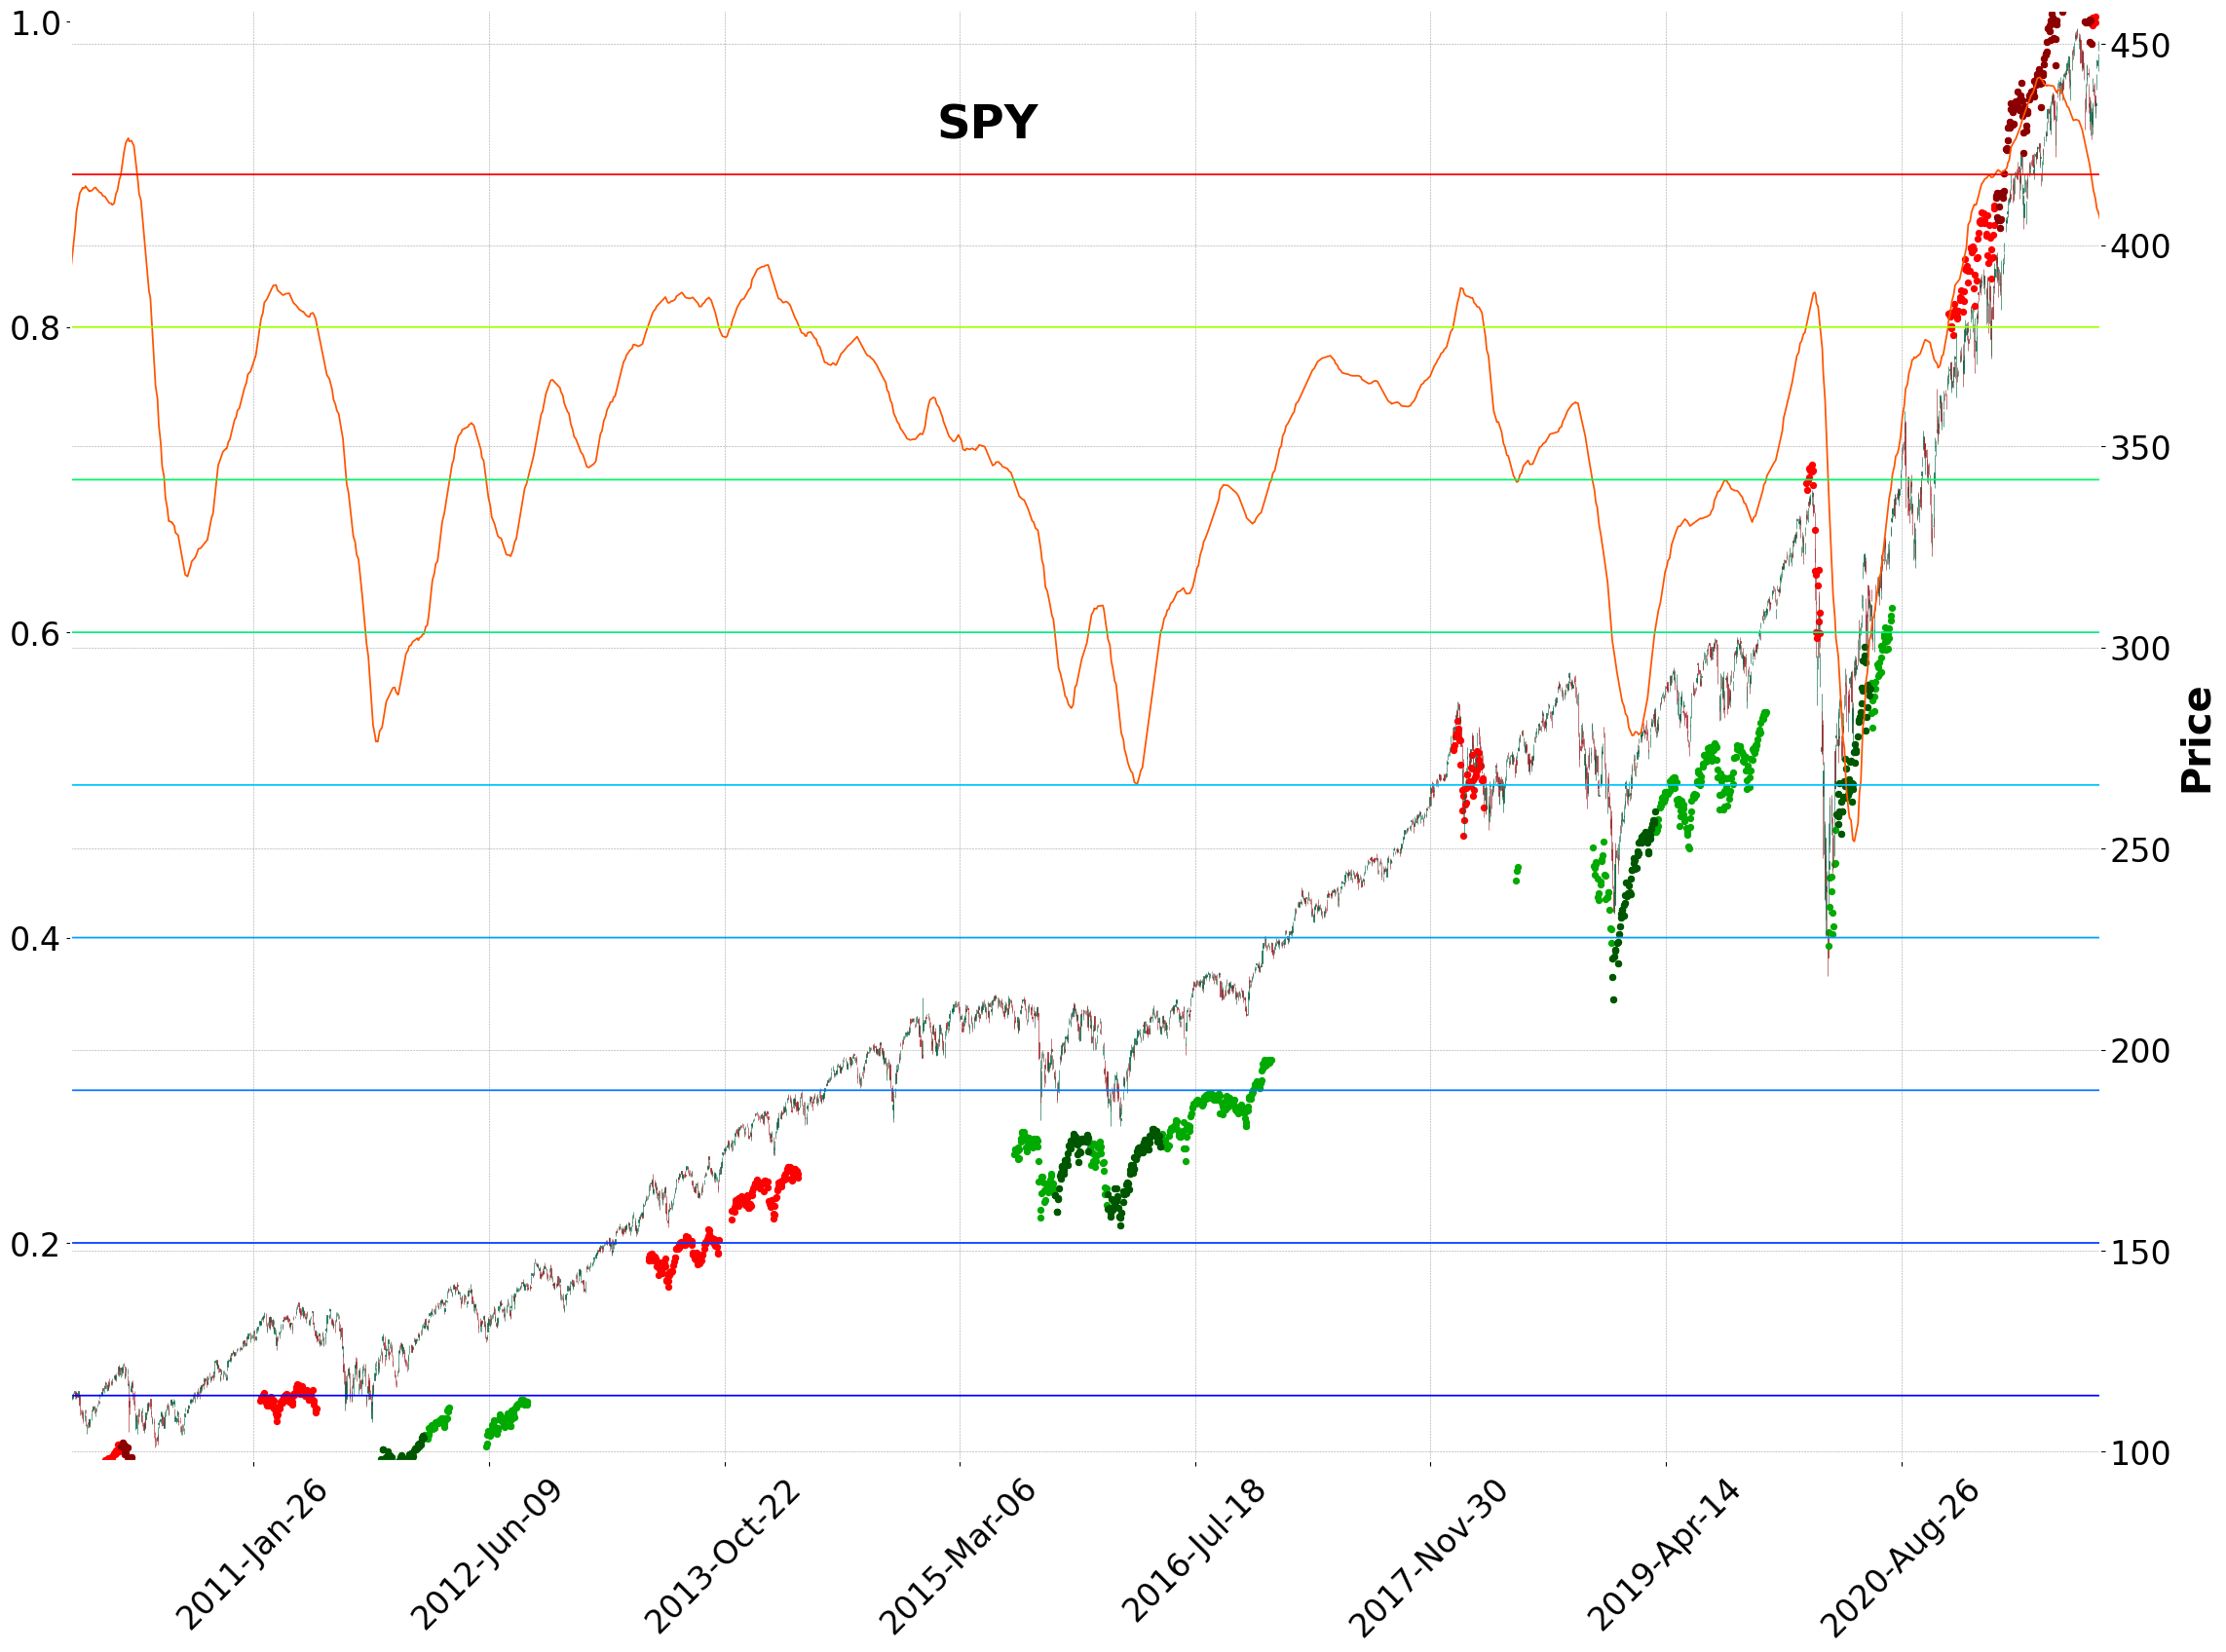

In [17]:
symbol = 'SPY'
syear = 2010
ticker = symbol
# download_multiple_stocks(1999, 1, 1, 2021, 10, 20, *tickers)
import yfinance
# df = yfinance.download(tickers=tickers, period="MAX")
# df.to_csv(ticker + ".csv")

# ticker = yfinance.Ticker(symbol)
# df = ticker.option_chain(ticker.options[0])
# # df[0]
df = get_df_from_csv('SPY')
data = get_df_from_csv(ticker)
indicators = ['risk','riskscatter'] 
# indicators = ['sma']
mplfinance_plot(data, ticker, indicators, 'candle', syear, 1, 1, 2021, 10, 22)
# get_df_from_csv('NS')